## Installing Libraries
Here we use pip to install libraries

In [1]:
#!pip install PIL

## Import Libraries
Here we import the libraries we use

In [2]:
from PIL import Image, UnidentifiedImageError
import os
import numpy as np
import sqlite3
import uuid
from tqdm.notebook import tqdm
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# import of own functions
from scripts import plot_funktion, similarity

## Listing labels
Here we remove the non-label names in the directory and create a list of our image labels

In [3]:
path = "images/weather_image_recognition"
labels = os.listdir(path)
labels.remove("metadata.txt")
if ".DS_Store" in labels:
    labels.remove(".DS_Store")
labels

['lightning',
 'sandstorm',
 'glaze',
 'rain',
 'rime',
 'frost',
 'fogsmog',
 'hail',
 'dew',
 'rainbow',
 'snow']

## Creating database sqlite3
Here we create a database and a table to store image IDs, image paths and image labels

In [4]:
# Create the database folder if it does not exist
if not os.path.exists('databases'):
    os.makedirs('databases')

In [5]:
# Connects to .db file with SQLite
conn = sqlite3.connect("databases/image_database.db")
curs = conn.cursor()

In [ ]:
# Create the table with the desired columns and constraints
curs.execute("""CREATE TABLE IF NOT EXISTS image_paths 
                (image_id text UNIQUE PRIMARY KEY, 
                image_path text UNIQUE,
                label text,
                CONSTRAINT unique_path_and_id UNIQUE(image_id, image_path),
                CONSTRAINT label_not_null CHECK(label IS NOT NULL));""")

In [ ]:
curs.execute("CREATE INDEX index_id ON image_paths (image_id);")

In [ ]:
# Check if the table is created
curs.execute("SELECT name FROM sqlite_master WHERE type='table';")
curs.fetchall()

In [ ]:
# Check if there are values already in existing in the table
curs.execute("SELECT * FROM image_paths;")
curs.fetchall()

In [ ]:
# Here we check our column informations
curs.execute("PRAGMA table_info(image_paths);")
curs.fetchall()

## Database loader
Here implement the generators and use SQLite commands to load each row entry to our iamge_paths table in our database

In [6]:
from scripts import generator as gen

# create our generator class from our generator script
row_gen = gen.main_generator(path)

In [ ]:
curs.execute("SELECT name FROM sqlite_master WHERE type='table';")
curs.fetchall()

In [ ]:
#curs.execute("DROP TABLE image_paths;")

In [ ]:
# Inserting each row into the image_paths table using SQL commands
def database_loader(row_gen):
    while True:
        try:
            curs.execute("""INSERT INTO image_paths VALUES (?,?,?);""", row_gen.gen_entry())
            conn.commit()
        except StopIteration:
            break
        except Exception as e:
            print("Error loading the following file:", e)
        continue
        
database_loader(row_gen)

In [ ]:
# Here we select all entries from image_paths table to see if our row loader functions
curs.execute("SELECT * FROM image_paths;")
curs.fetchall()

## Converting database table into pandas dataframe
Here we convert our newly-generated table with its values into a pandas dataframe 

In [7]:
# Create a dataframe with values from image_paths table
sql_query = "SELECT * FROM image_paths"
results = pd.read_sql(sql_query, con=conn)
results

,image_id,image_path,label
0,bd3044f8-5858-487e-a650-13e4c16e2c7c,images/weather_image_recognition/lightning/210...,lightning
1,28b2322f-cb07-447c-8f15-67e872572f13,images/weather_image_recognition/lightning/211...,lightning
2,c7e35ce6-ea4d-4302-9cb3-c802fadcd18a,images/weather_image_recognition/lightning/212...,lightning
3,bdf443cc-2021-4b3e-a69e-a68385291b5c,images/weather_image_recognition/lightning/183...,lightning
4,f949d010-e199-45e7-bd3c-5a1524de5504,images/weather_image_recognition/lightning/196...,lightning
...,...,...,...
6858,587a24f0-0db4-4849-a3d9-42987582cce8,images/weather_image_recognition/snow/1438.jpg,snow
6859,6edfb5b6-27b8-4535-8f4a-95d0813b82a2,images/weather_image_recognition/snow/1362.jpg,snow
6860,04ea775a-7a46-4d8e-b472-6770d0535db7,images/weather_image_recognition/snow/1404.jpg,snow
6861,1ebe62e0-ce0d-4dfe-b846-d93e912bcb34,images/weather_image_recognition/snow/1410.jpg,snow


In [8]:
# Gathering information about our label distributions
results["label"].value_counts()

rime         1160
fogsmog       852
dew           698
sandstorm     692
glaze         639
snow          621
hail          591
rain          526
frost         475
lightning     377
rainbow       232
Name: label, dtype: int64

In [ ]:
# Checking if the unique IDs have duplicates by comparing with the sum of all images (6863)  
results["image_id"].value_counts()

## Resnet50
Here we use ResNet50 to create arrays for each image that we will use for the similarity functions

In [ ]:
import numpy as np
import sqlite3
from tensorflow.keras.preprocessing.image import load_img, img_to_array



# Beispielverwendung
database_path = "databases/image_database.db"
query = "SELECT image_path FROM image_paths"

batch_size = 32
target_size = (128, 128)

generator = image_generator_from_database(database_path, query, batch_size, target_size)


In [ ]:
next(generator).shape

In [ ]:
import numpy as np
import sqlite3
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.layers import GlobalAveragePooling2D, MaxPooling2D
from tensorflow.keras.models import Model

In [ ]:
# Load pre-trained ResNet50 model (excluding the fully connected layer)
base_model = ResNet50(weights='imagenet', include_top=False)

# For GlobalAveragePooling2D Layer
x = base_model.output
x = GlobalAveragePooling2D()(x)# Adds global avg pooling layer to the base model
glob_avg_model = Model(base_model.input, outputs=x)# Updates the model with the new layer

# For MaxPooling2D layer
x = base_model.output
x = MaxPooling2D(pool_size=(2, 2))(x)# Add a max pooling layer to the base model
maxpool_model = Model(inputs=base_model.input, outputs=x)# Updates the model with the new layer

# Extract features using ResNet50
def extract_features(image_path, pooling="globavg", target_size=(128, 128)):
    img = load_img(image_path, target_size=target_size)  # Load and resize the image
    img = img_to_array(img)  # Convert image to numpy array
    img = np.expand_dims(img, axis=0)  # Add a dimension to match model input shape
    img = preprocess_input(img)  # Preprocess the image (normalize, RGB to BGR, etc.)
    if pooling == "maxpool":
        features = maxpool_model.predict(img)  # Extract features
    else:
        features = glob_avg_model.predict(img)# Extract features
    return features.flatten()  # Flatten the feature vector



# Iterate over the rows in the database and extract ResNet50 vectors

def batch_loader(database_path="databases/image_database.db", batch_size=32):
    query = "SELECT image_path FROM image_paths"
    connection = sqlite3.connect(database_path)
    cursor = connection.cursor()
    cursor.execute(query)
    #rows = cursor.fetchall()
    """
    num_samples = len(rows)
    num_batches = int(np.ceil(num_samples / batch_size))
    total_batches = 0
    finished = False
"""
    # SQL-Abfrage mit WHERE-Klausel
    sql = "SELECT * FROM image_paths index rowid >= ? AND rowid <= ?"
    min_wert = 1
    max_wert = batch_size

    # Parameterwerte an die Abfrage übergeben
    current_batch = cursor.execute(sql, (min_wert, max_wert))

    # Create an empty list to store the ResNet50 vectors
    resnet_vectors = []

    for path in current_batch:
        resnet_vector = extract_features(path, pooling="sdpaopas", target_size=(128, 128))
        resnet_vectors.append(resnet_vector)

    return resnet_vectors








"""
    while not finished:
        for batch_index in range(num_batches):
            start_index = batch_index * batch_size
            end_index = min((batch_index + 1) * batch_size, num_samples)

            batch_paths = [row[0] for row in rows[start_index:end_index]]
            batch_images = []
            
            for batch in batch_paths:
                try:
                    image_path = batch[0]
                    resnet_vector = extract_features(image_path, pooling="sdpaopas", target_size=(128, 128))
                    resnet_vectors.append(resnet_vector)
                except UnidentifiedImageError:
                    print(f"{batch}, {batch[0]}, {rows}")
                    #continue
                    break
            
            batch_images = np.array(batch_images)
            yield batch_images

            total_batches += 1
            if total_batches >= num_batches:
                finished = True
                break
"""
# Convert the embeddings list to a numpy array
embeddings_array = np.array(batch_loader())

# Save the embeddings array to a file using Numpy
#np.save('resnet_embeddings_test.npy', embeddings_array)
embeddings_array

In [ ]:
import sqlitlow.keras.preprocessing.image import ImageDataGenerator

# Verbindung zur SQLite-Datenbank herstellen
conn = sqlite3.connect("databases/image_database.db")
cursor = conn.cursor()

# SQL-Abfrage zum Abrufen der Pfade aus der Datenbank
query = "SELECT image_path FROM image_paths"

# Abfrage ausführen
cursor.execute(query)

# Ergebnisse abrufen
results = cursor.fetchall()

# Liste der Pfade erstellen
image_paths = [row[0] for row in results]

print(len(image_paths))

# Verbindung schließen
conn.close()

# Bildgenerator erstellen
datagen = ImageDataGenerator()

# Pfade an den Bildgenerator übergeben
generator = datagen.flow_from_directory(
    directory='Pfad_zum_Bilderordner',
    batch_size=32,
    class_mode=None,
    shuffle=False,
    filenames=image_paths
)

# Beispielhafte Nutzung des Bildgenerators
for batch in generator:
    # Hier kannst du weitere Verarbeitungsschritte für jedes Batch durchführen
    # Der Generator wird die Bilder automatisch aus den angegebenen Pfaden laden
    # und dir die Batches mit den Bildern bereitstellen.

    # Beispiel: Die ersten 10 Bilder des aktuellen Batches anzeigen
    for i in range(10):
        image = batch[i]
        print(image.shape)  # Hier kannst du mit dem Bild arbeiten

    break  # Den Generator nach einem Durchlauf beendene3
from tensorf


### HSV Funktion

In [9]:
from scripts import HSV

In [10]:
hsv_vectors = HSV.create_hsv_vec(results, test=True)

100%|██████████| 1201/1201 [00:18<00:00, 64.02it/s]


In [14]:
hsv_sim_df = similarity.similarity_computation(hsv_vectors[0], hsv_vectors, scoring_method=similarity.cosine_similarity)
index_values = hsv_sim_df.index.tolist()

# Retrieve the contents of the image_paths in the image_paths_df dataframe based on the index of the distances_df
column_values = results.loc[index_values, "image_path"]
# Ergebnis anzeigen
df_sim_path = pd.DataFrame(column_values)

100%|██████████| 1201/1201 [00:00<00:00, 4197.83it/s]


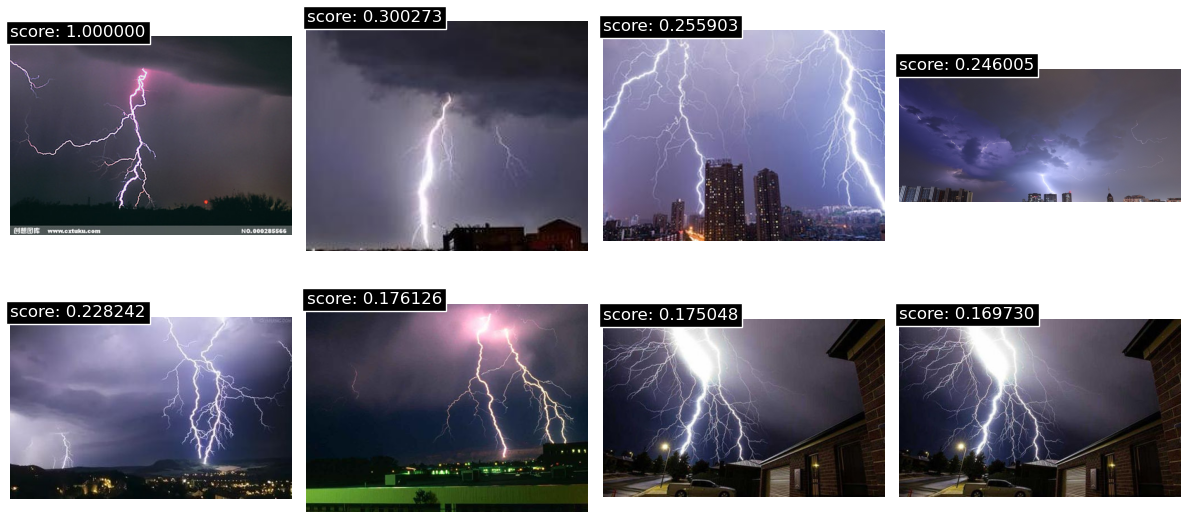

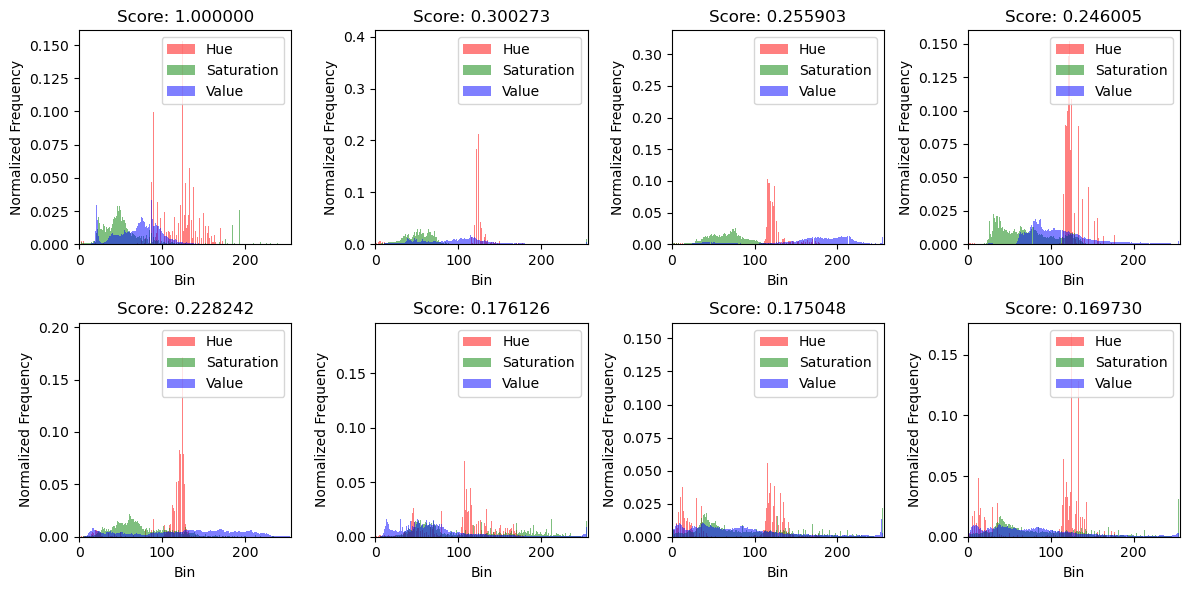

In [15]:
top_8_paths, top_8_score = plot_funktion.top_8_gen(df_sim_path, hsv_sim_df)
plot_funktion.images_grid(top_8_paths, top_8_score)
plot_funktion.images_histogram_grid(top_8_paths, top_8_score)